<a href="https://colab.research.google.com/github/RodriMenendez/BIO_LM_SURF/blob/main/Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Setup

In [1]:
!pip install wandb

In [2]:
!wandb login

wandb: Currently logged in as: aavelarm (surf-2023). Use `wandb login --relogin` to force relogin


In [3]:
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torchsummary import summary

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import wandb
import time

## Data Preprocessing

In [4]:
path = '/content/drive/MyDrive/SURF_2023/Practice'

transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
train_data = torchvision.datasets.CIFAR10(root=path+'/cifar10', train=True, transform=transform, download=True)

batch_size = 32
trainloader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

Files already downloaded and verified


In [5]:
test_data = torchvision.datasets.CIFAR10(root=path+'/cifar10', train=False, transform=transform, download=True)
testloader = torch.utils.data.DataLoader(test_data, batch_size=batch_size,
                                          shuffle=False, num_workers=2)

Files already downloaded and verified


In [6]:
classes = ['plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

## Image Example

Text(0.5, 1.0, 'truck')

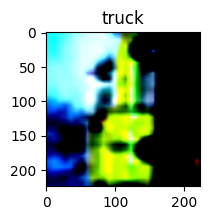

In [7]:
i = np.random.randint(0, high=len(train_data))

plt.figure(figsize=(2, 2))
plt.imshow(np.array(train_data[i][0]).T)
plt.title(classes[train_data[i][1]])

## RestNet tutorial
Link: https://pytorch.org/hub/pytorch_vision_resnet/ \
Downloding model and getting output

In [8]:
model = torchvision.models.resnet18(weights='DEFAULT')
# pre-trained model weights kept constant
# for param in model.parameters():
#     param.requires_grad = False

In [9]:
# Download ImageNet labels
!wget https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt

--2023-06-29 05:15:00--  https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10472 (10K) [text/plain]
Saving to: ‘imagenet_classes.txt.4’

imagenet_classes.tx 100%[===================>]  10.23K  --.-KB/s    in 0s      

2023-06-29 05:15:00 (86.3 MB/s) - ‘imagenet_classes.txt.4’ saved [10472/10472]



In [10]:
# Read the categories
with open("imagenet_classes.txt", "r") as f:
    categories = [s.strip() for s in f.readlines()]

## Adding Classification Head

In [11]:
class Classification(nn.Module):
    def __init__(self, pretrained_model):
        super().__init__()
        self.pretrained_model = pretrained_model
        self.layer1 = nn.Linear(1000, 1000)
        self.layer2 = nn.Linear(1000, 10)

    def probabilities(self, x):
        output =  self.pretrained_model(x)
        output = F.relu(self.layer1(output))
        output = F.softmax(self.layer2(output), dim=1)

        return output

    def forward(self, x):
        output = self.probabilities(x)
        output = torch.argmax(output, dim=1)

        return output

In [12]:
clf_model = Classification(model)
if torch.cuda.is_available():
    clf_model.cuda()

In [13]:
from IPython.display import Javascript

display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 185})'''))
summary(clf_model, input_size=(3, 224, 224))

<IPython.core.display.Javascript object>

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

## Training

In [14]:
lr = 1e-3
momentum = 0.9

loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(clf_model.parameters(), lr=lr, momentum=momentum)

In [15]:
def train_step(trainloader, model):
    correct = 0
    step_loss = 0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data

        if torch.cuda.is_available():
            inputs, labels = inputs.cuda(), labels.cuda()

        one_hot_labels = F.one_hot(labels, 10)

        # zero parameter gradients
        optimizer.zero_grad()

        # update values
        output = model.probabilities(inputs)
        loss = loss_func(output, one_hot_labels.float())
        step_loss += loss
        loss.backward()
        optimizer.step()

        # get classification accuracy
        accuracy_output = model(inputs)
        correct += (accuracy_output == labels).float().sum()

    step_loss /= len(trainloader)
    return step_loss, correct

def test_step(testloader, model):
    correct = 0
    for i, data in enumerate(testloader, 0):
        inputs, labels = data

        if torch.cuda.is_available():
            inputs, labels = inputs.cuda(), labels.cuda()

        output = model(inputs)

        correct += (output == labels).float().sum()

    return correct

In [16]:
def train(trainloader, testloader, model, epochs, log = False):
    for t in range(epochs):
        loss, train_correct = train_step(trainloader, model)
        train_accuracy = train_correct/len(train_data)

        test_correct = test_step(testloader, model)
        test_accuracy = test_correct/len(test_data)

        print(f'|Epoch: {t}\t|Loss: {loss:.3}\t|Train Accuracy: {train_accuracy:.3}\t|Test Accuracy: {test_accuracy:.3}')

        if log:
            wandb.log({"train_acc": train_accuracy, "test_acc": test_accuracy, "loss": loss})

In [17]:
epochs = 4

wandb.init(
    project = "CIFAR10-Resnet18-Classification",
    config={
        "learning rate": lr,
        "momentum": momentum,
        "epochs": epochs,
        "dataset": "CIFAR10",
        "architecture": "Resnet18"
    }
)

wandb: Currently logged in as: aavelarm (surf-2023). Use `wandb login --relogin` to force relogin


In [18]:
train(trainloader, testloader, clf_model, epochs, True)

|Epoch: 0	|Loss: 1.7	|Train Accuracy: 0.801	|Test Accuracy: 0.879
|Epoch: 1	|Loss: 1.56	|Train Accuracy: 0.928	|Test Accuracy: 0.909
|Epoch: 2	|Loss: 1.53	|Train Accuracy: 0.949	|Test Accuracy: 0.913
|Epoch: 3	|Loss: 1.51	|Train Accuracy: 0.961	|Test Accuracy: 0.922


In [19]:
wandb.finish()

loss,█▃▂▁
test_acc,▁▆▆█
train_acc,▁▇▇█
loss,1.51457
test_acc,0.9223
train_acc,0.96086


## Saving Model

In [20]:
timestr = time.strftime("%Y%m%d-%H%M%S")

path = '/content/drive/MyDrive/SURF_2023/Practice/models/clf_model' + timestr
torch.save(clf_model.state_dict(), path)

In [21]:
## using model
# clf_model = Classification(model)
# clf_model.load_state_dict(torch.load(path))

Text(0.5, 1.0, 'Predicted: cat Actual: dog')

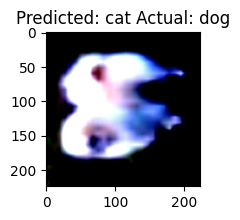

In [41]:
i = np.random.randint(0, high=len(train_data))

predicted = classes[clf_model(torch.reshape(train_data[i][0].cuda(), (1, 3, 224, 224))).item()]
actual = classes[train_data[i][1]]

plt.figure(figsize=(2, 2))
plt.imshow(np.array(train_data[i][0]).T)
plt.title(f'Predicted: {predicted} Actual: {actual}')